In [14]:
print("Hello, world!")
print("Starting project...")

Hello, world!
Starting project...


In [15]:
# Imports
print("Importing libraries...")
# YOLO STUFF
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# my stuff
import cv2 as cv
import os
import io
import glob
import PIL
from IPython.display import clear_output, Image, display

print("Done importing libraries.")

Importing libraries...
Done importing libraries.


In [29]:
### global stuff
# DATA_FOLDER:
# contains data_labels.txt, with_rips folder images and without_rips folder images
DATA_FOLDER = "./data/training_data" 
RIPS_FOLDER = "./data/training_data/with_rips" 
YOLO_ANNOTATIONS_FOLDER = "./data/training_data/yolo_annotations/"

yolo_annotations_files = glob.glob(os.path.join(YOLO_ANNOTATIONS_FOLDER, "*.txt")) 
images_rip = glob.glob(os.path.join(DATA_FOLDER, "with_rips/*.png")) 
images_norip = glob.glob(os.path.join(DATA_FOLDER, "without_rips/*.png")) 

### CONTROL VARIABLES
CREATE_YOLO_ANNOTATIONS = False 

In [136]:
# Reading the RIP annotation from the paper's dataset
# After we read it, we convert it to yolo's format
def read_RIP_annotations(filename = os.path.join(DATA_FOLDER, "data_labels.txt")):
    print("Reading file", filename)
    file = open(filename, "r")
    
    labels = file.readline()
    print("File labels:", labels)
    new_line = file.readline()
    
    images_dict = []
    while (new_line):
        # Get details from annotation line
        items = new_line.split(',')
        image_details = {}
        image_details['filename'] = items[0]
        
        image_details['xmin'] = items[1]
        image_details['ymin'] = items[2]
        image_details['xmax'] = items[3]
        image_details['ymax'] = items[4]
 
        image_details['class'] = items[5][:-1]
        
        # Read image for width and height
        image_path = glob.glob(os.path.join(RIPS_FOLDER, image_details['filename'])) 
        image = PIL.Image.open(image_path[0])
        width, height = image.size
        image_details["width"] = width
        image_details["height"] = height
        image_details["image"] = image
        
        new_line = file.readline()
        
        images_dict.append(image_details)
    
    file.close()
    print("Finished parsing data from file.")
    return images_dict
        
# yolo bbox format: b_class, b_center_x, b_center_y, b_width, b_height
# This function takes the dictionary generated at the previous function, reads it, creates a line of yolo format and writes a file for each image
def convert_to_yolo(images_dict):
    for image in images_dict:
        filename = image['filename'][:-4] + '.txt'
        file_full_path = os.path.join(DATA_FOLDER, "yolo_annotations", filename)
        file = open(file_full_path, "w")
        
        # bbox coordonates for yolo format
        b_center_x = (int(image['xmin']) + int(image['xmax'])) / 2
        b_center_y = (int(image['ymin']) + int(image['ymax'])) / 2
        b_width = (int(image['xmax']) - int(image['xmin']))
        b_height = (int(image['ymax']) - int(image['ymin']))
        
        # Normalise the coordinates by the dimensions of the image
        b_center_x /= int(image['width'])
        b_center_y /= int(image['height'])
        b_width /= int(image['width'])
        b_height /= int(image['height'])
        
        b_center_x = round(b_center_x, 3)
        b_center_y = round(b_center_y, 3)
        b_width = round(b_width, 3)
        b_height = round(b_height, 3)
        
        yolo_line = ", "
        yolo_items = [image["class"], str(b_center_x), str(b_center_y), str(b_width), str(b_height)]
        yolo_line = yolo_line.join(yolo_items)
        
        file.write(yolo_line)
        file.close()
    
# Reads the annotations from the yolo files into a dictionary of dictionaries. A bit redundant and will have to change, but I want to be able to read the data directly.
# Format: yolo_dict[<filename>] = {'class', 'b_center_x', 'b_center_y', 'b_width', 'b_height'}
def read_yolo_annotations():
    yolo_dict = {}
    for yolo_file in yolo_annotations_files:
        filename = yolo_file.split('/')[-1].split('.')[-2]
        file = open(yolo_file, 'r')
        line = file.readline()
        split_line = line.split(',')
        yolo_dict[filename] = {}
        if (yolo_dict[filename]):
            print ("Key exists ", filename)
        else:
            yolo_dict[filename]['class'] = split_line[0]
            yolo_dict[filename]['b_center_x'] = split_line[1]
            yolo_dict[filename]['b_center_y'] = split_line[2]
            yolo_dict[filename]['b_width'] = split_line[3]
            yolo_dict[filename]['b_height'] = split_line[4]
        file.close()
    return yolo_dict

def draw_yolo_annotations(image, yolo_annotations):
    full_name = image + '.png'
    img_original = cv.imread(os.path.join(RIPS_FOLDER, full_name))
    img_details = PIL.Image.open(os.path.join(RIPS_FOLDER, full_name))
    img = img_original.copy()
    width, height = img_details.size
    b_center_x = int(float(yolo_annotations[image]['b_center_x']) * width)
    b_center_y = int(float(yolo_annotations[image]['b_center_y']) * height)
    b_width = int(float(yolo_annotations[image]['b_width']) * width)
    b_height = int(float(yolo_annotations[image]['b_height']) * height)
    
    b_min_x = b_center_x - int(b_width / 2)
    b_min_y = b_center_y - int(b_height / 2)
    
    b_max_x = b_center_x + int(b_width / 2)
    b_max_y = b_center_y + int(b_height / 2)
    
#     img_circle = cv.circle(img, (b_center_x, b_center_y), 5, (0, 0, 0), 5)
    img_rect = cv.rectangle(img, (b_max_x, b_max_y), (b_min_x, b_min_y), (0, 0, 255), 2)
#     show_image(img)
    return img_rect

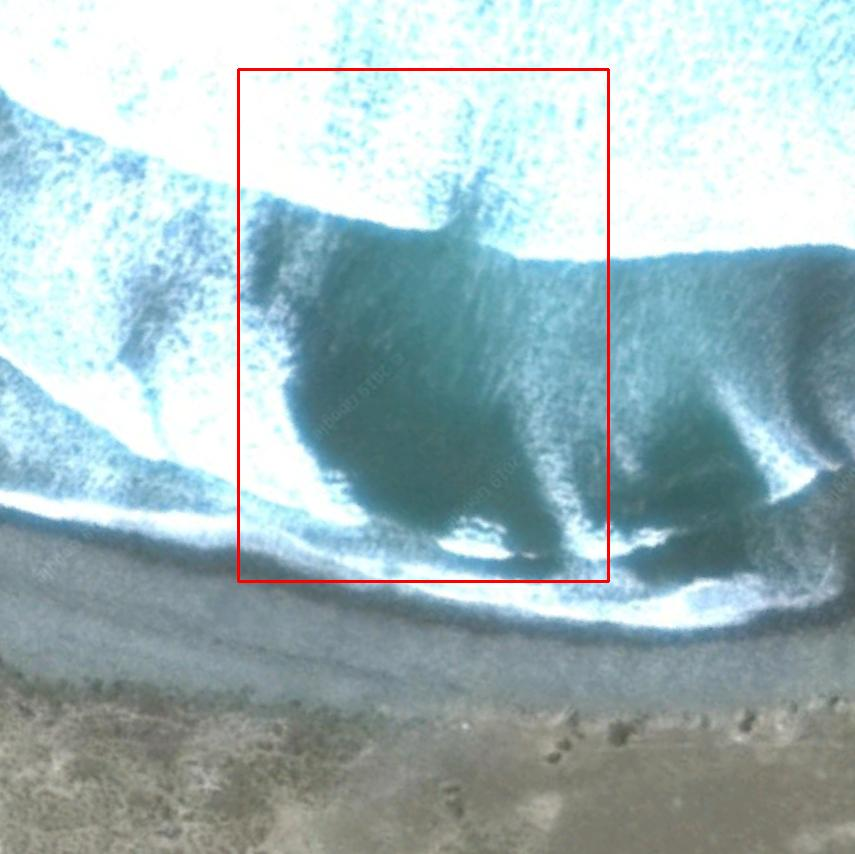

In [137]:
yolo_annotations = read_yolo_annotations()
# print(yolo_annotations)

yolo_bbox_image = draw_yolo_annotations('rip-1568', yolo_annotations)
show_image(yolo_bbox_image)

In [98]:
if (CREATE_YOLO_ANNOTATIONS == True):
    print("Reading labels...")
    images_dict = read_RIP_annotations()
    print("Converting annotations to yolo format and writing files")
    convert_to_yolo(images_dict)
else:
    print("Yolo annotations already created (assumption). Skipping the read and write part.")

# display(images_dict[0]['image'])

Yolo annotations already created (assumption). Skipping the read and write part.


In [82]:
#### Test functions box
from IPython.display import clear_output, Image, display

def print_initial_bbox(images_dict):
    for image in images_dict: 
        img_original = cv.imread(os.path.join(RIPS_FOLDER, image["filename"]))
        img = img_original.copy()
        cv.rectangle(img, (int(image['xmax']), int(image['ymax'])), (int(image['xmin']), int(image['ymin'])), (0, 0, 255), 2)
        show_image(img)
        
# def print_yolo_bbox(image, annotation):
#     annotation
    

def show_image(a, fmt='jpeg'):
    if(len(a.shape)) == 3:
        a = cv.cvtColor(a, cv.COLOR_BGR2RGB)
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
    
    
def read_image(index, source, resize):
    image = cv.imread(source[index])
    return cv.resize(image, (0, 0), fx=resize, fy=resize)
    

rip-1568.png


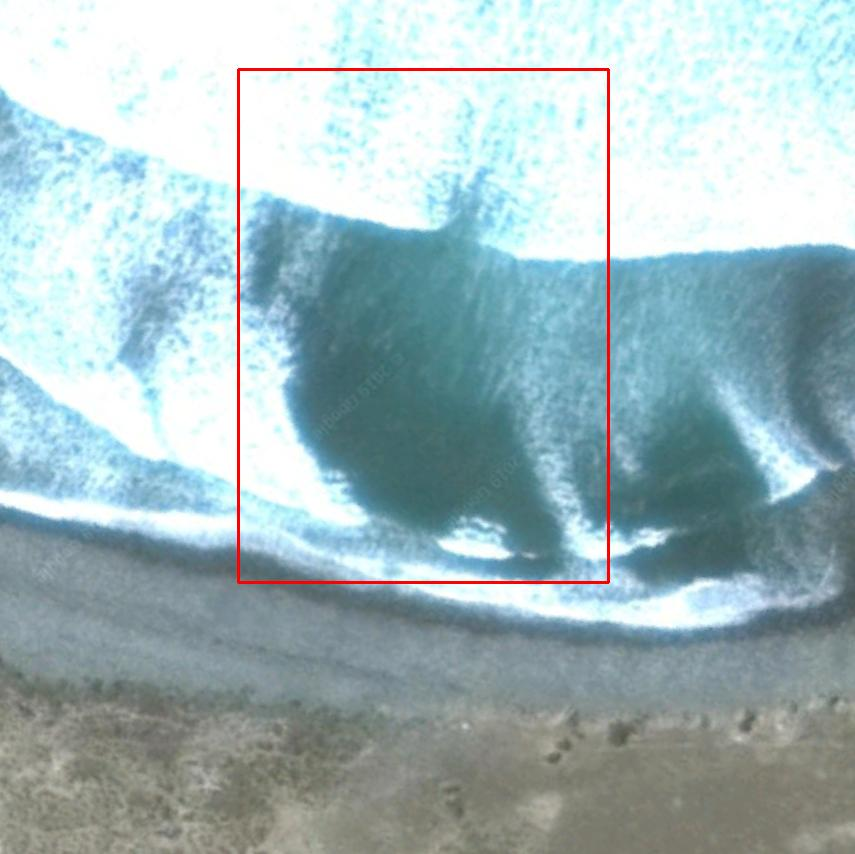

rip-581.png


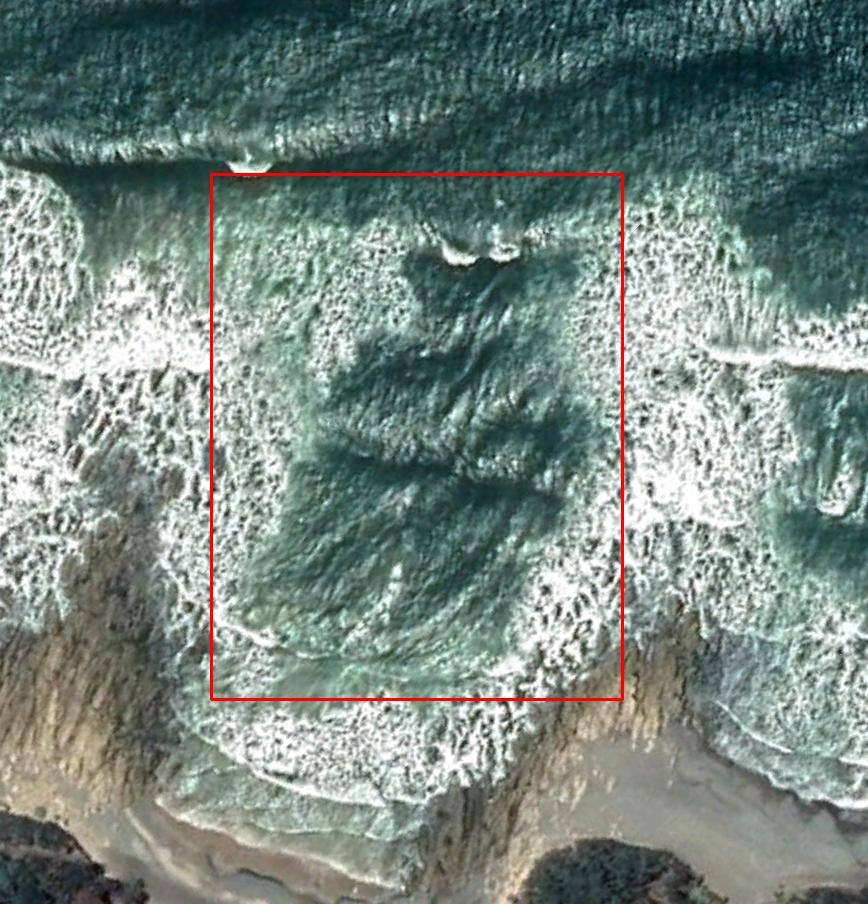

rip-1366.png


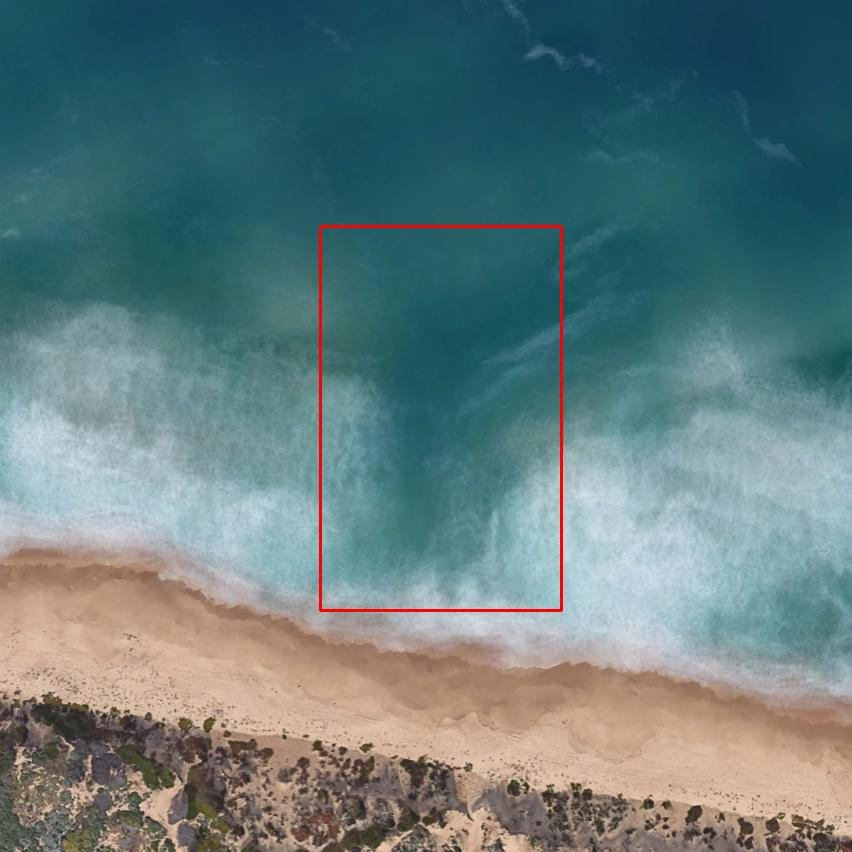

rip-1600.png


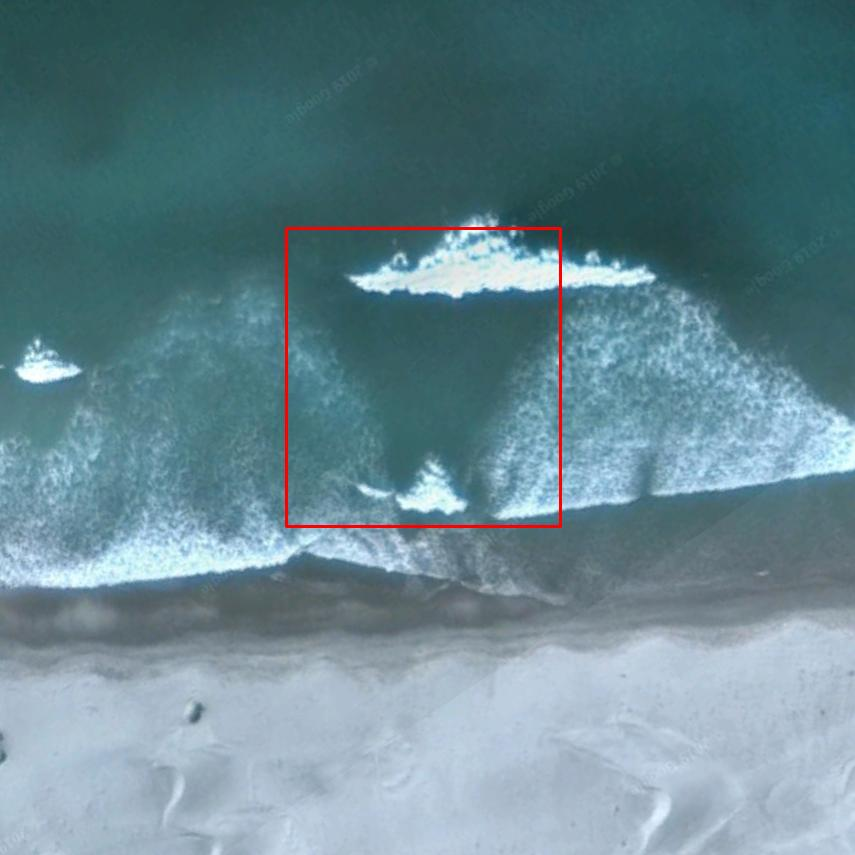

rip-613.png


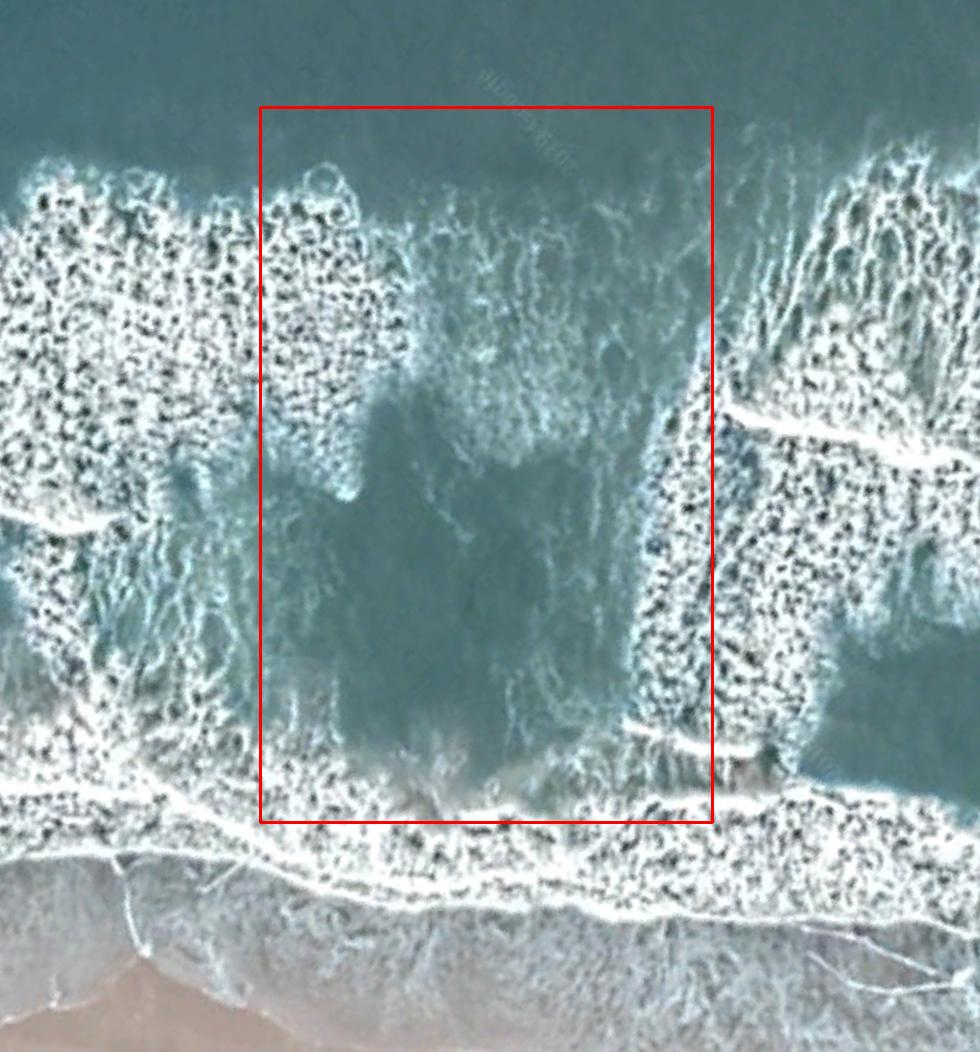

rip-1398.png


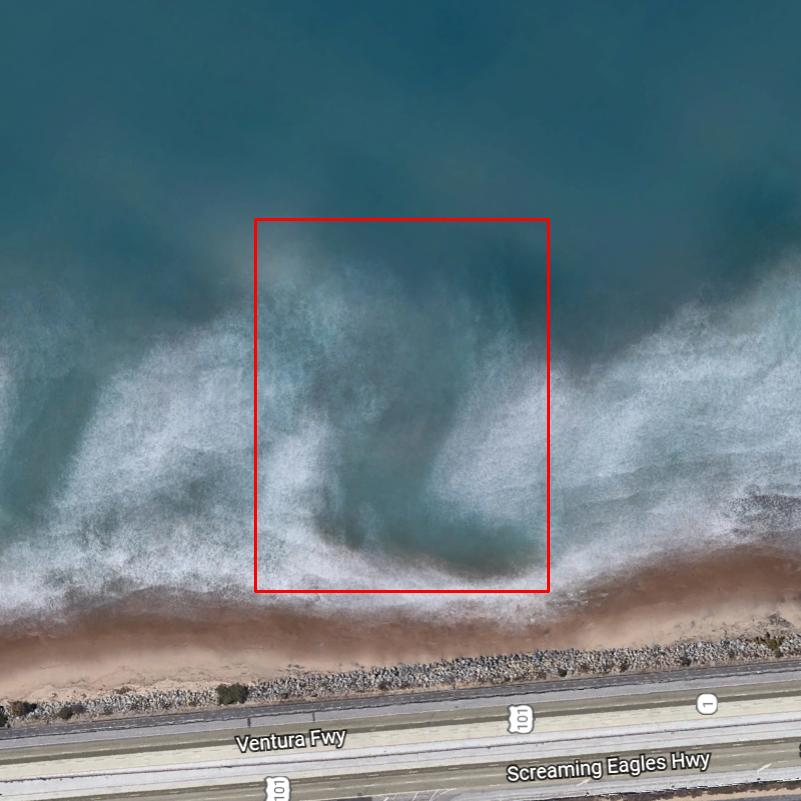

rip-1632.png


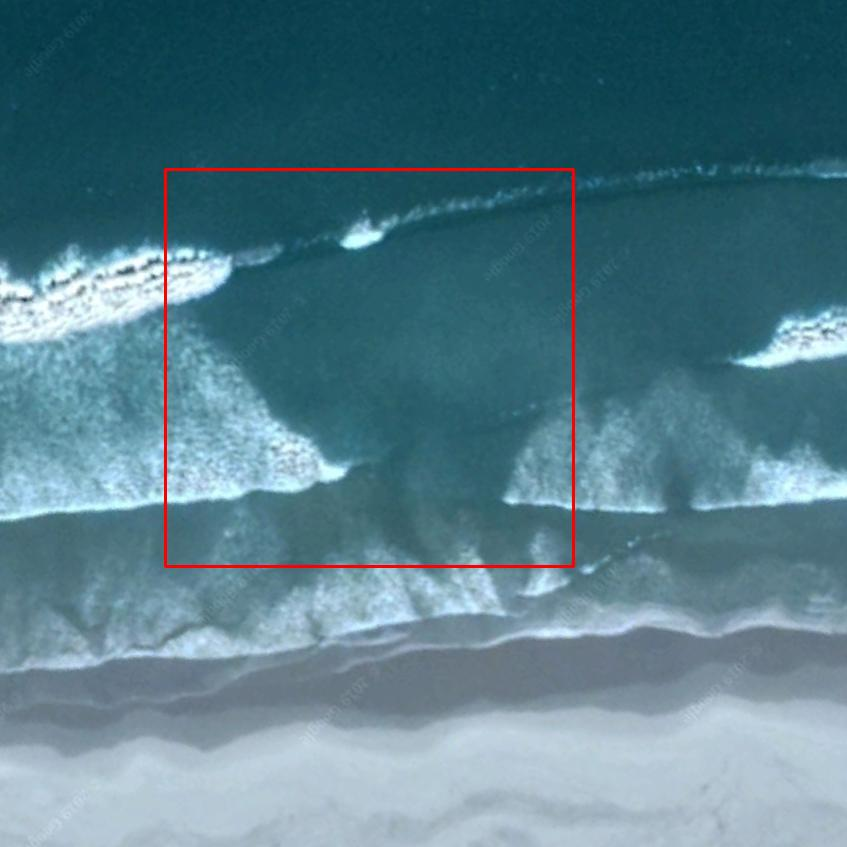

rip-645.png


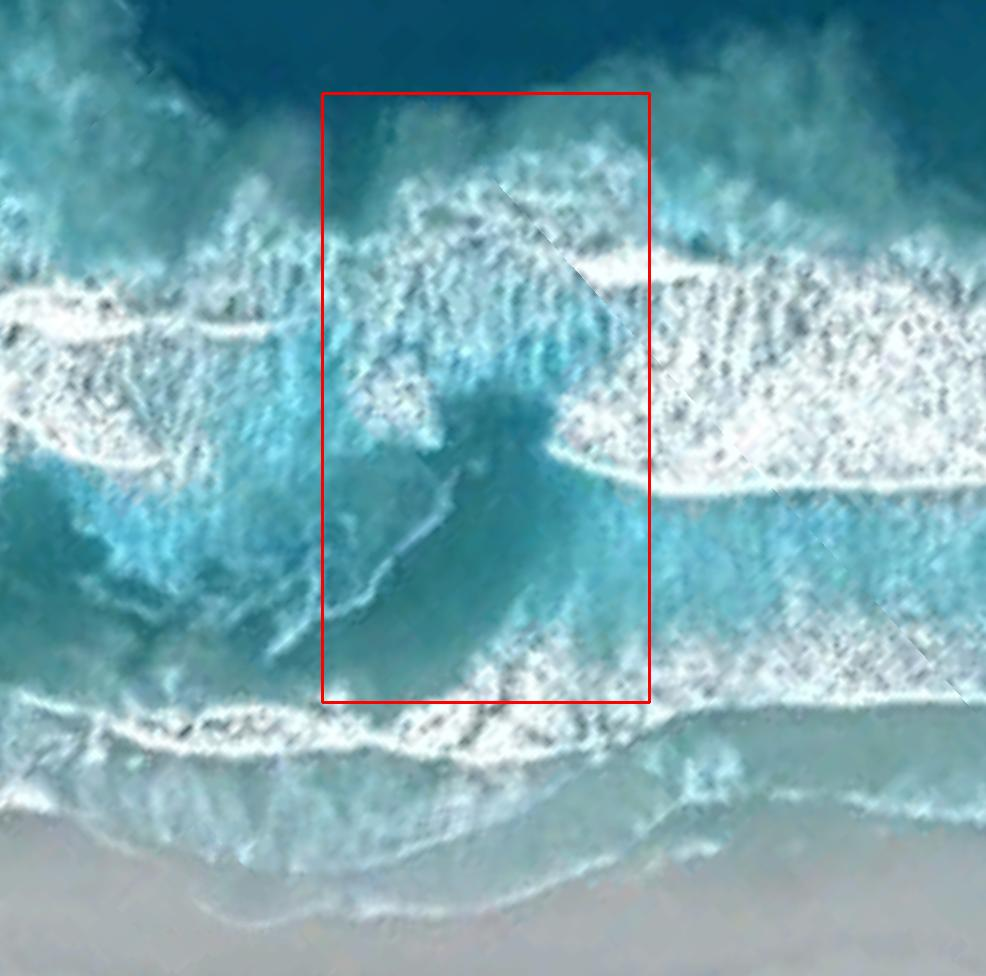

rip-1435.png


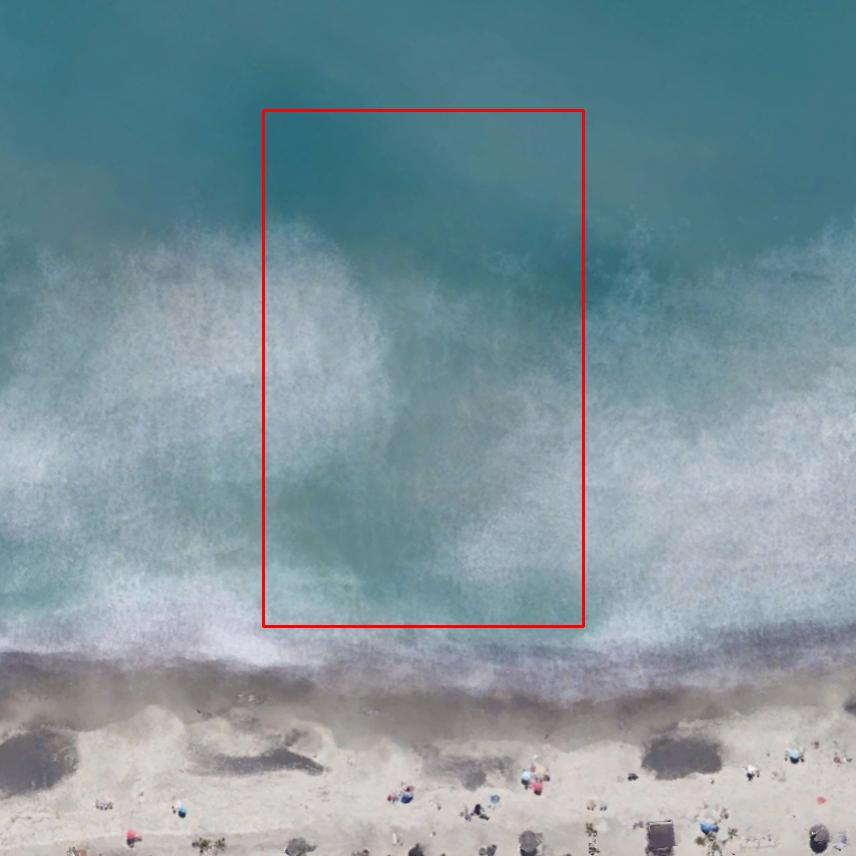

rip-1664.png


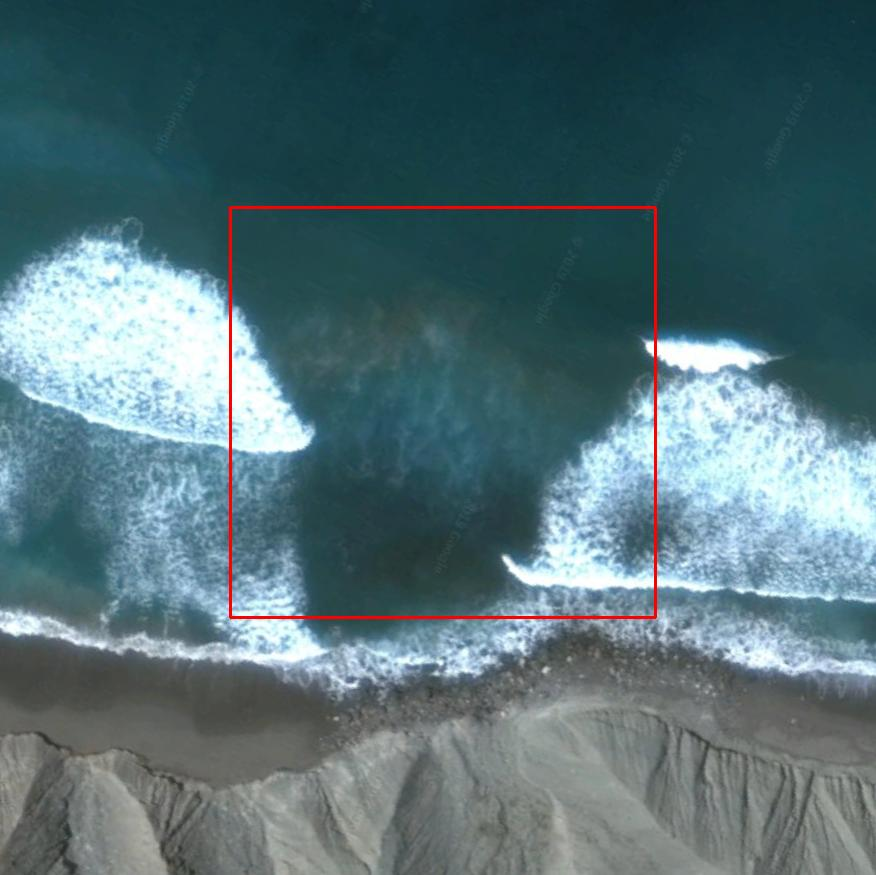

rip-677.png


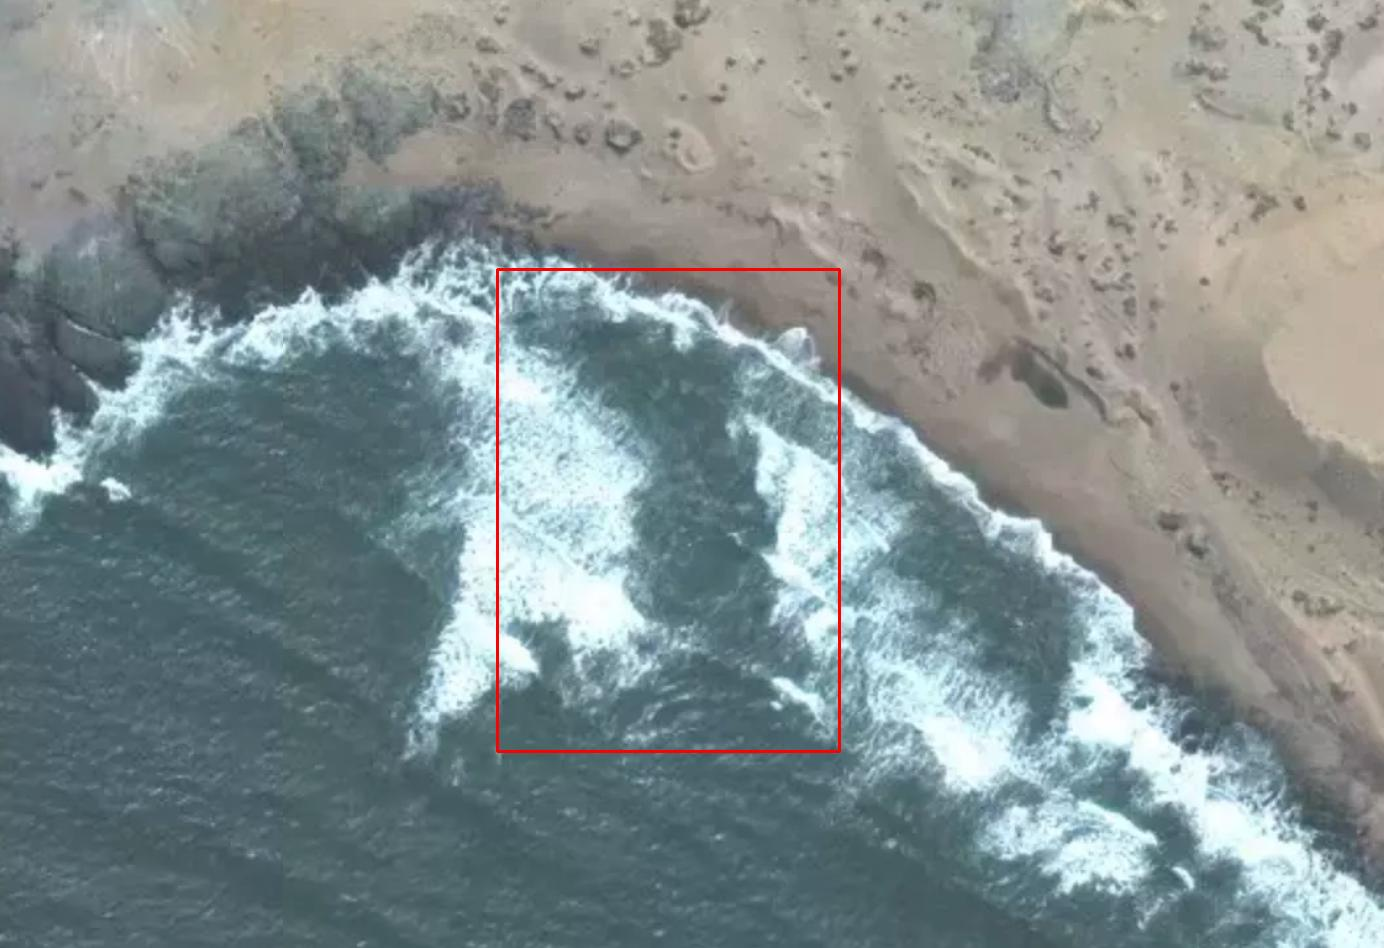

rip-1467.png


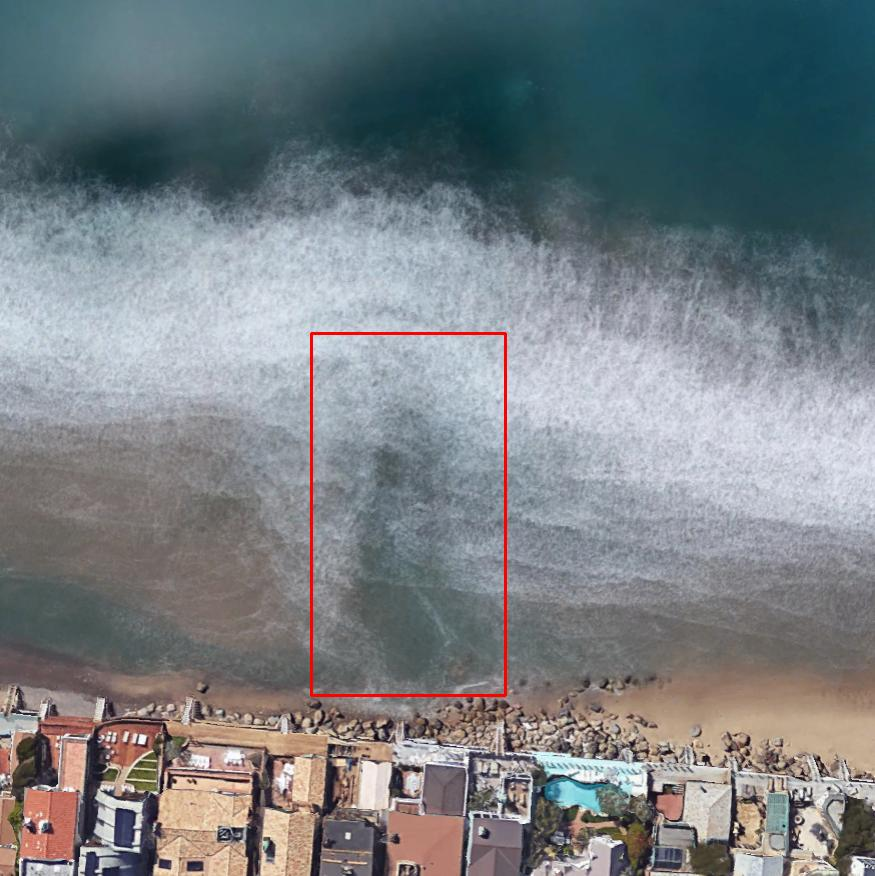

rip-1696.png


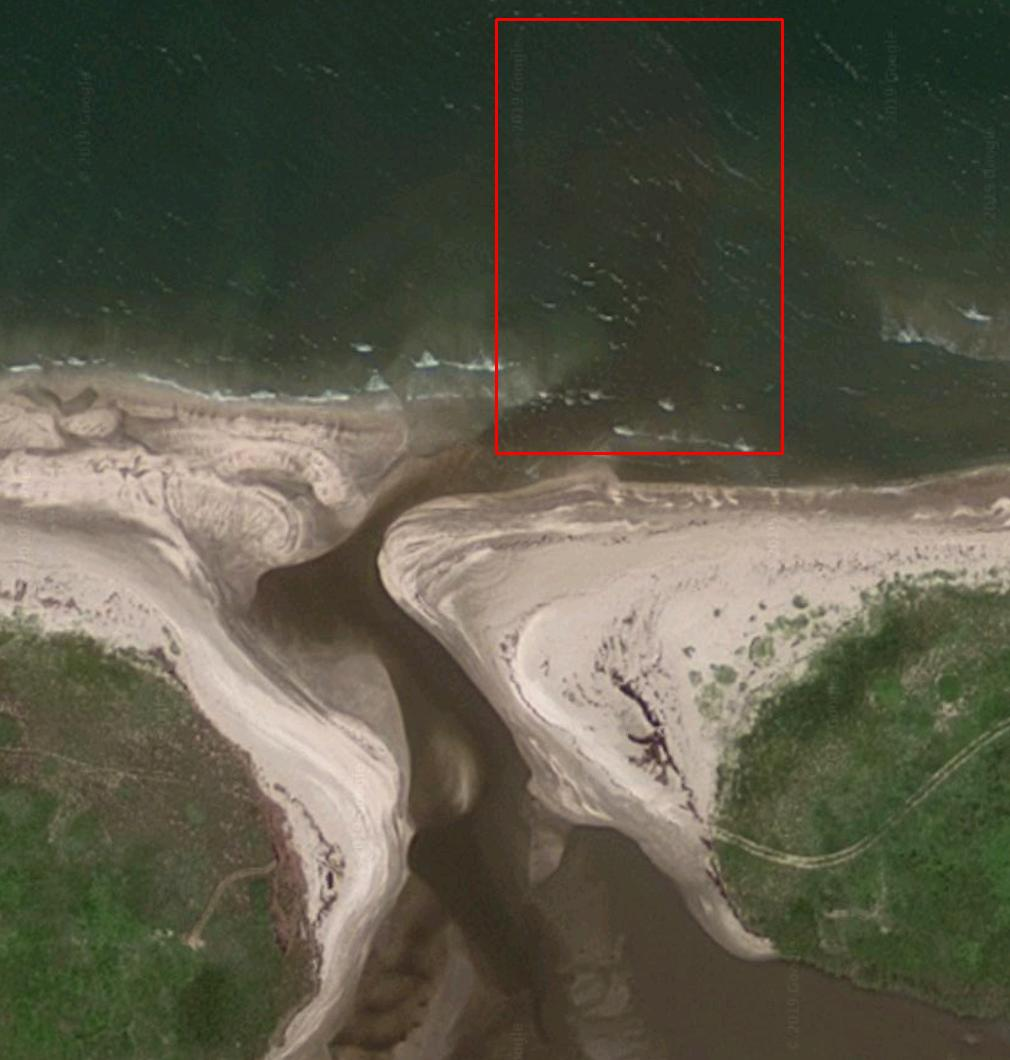

rip-709.png


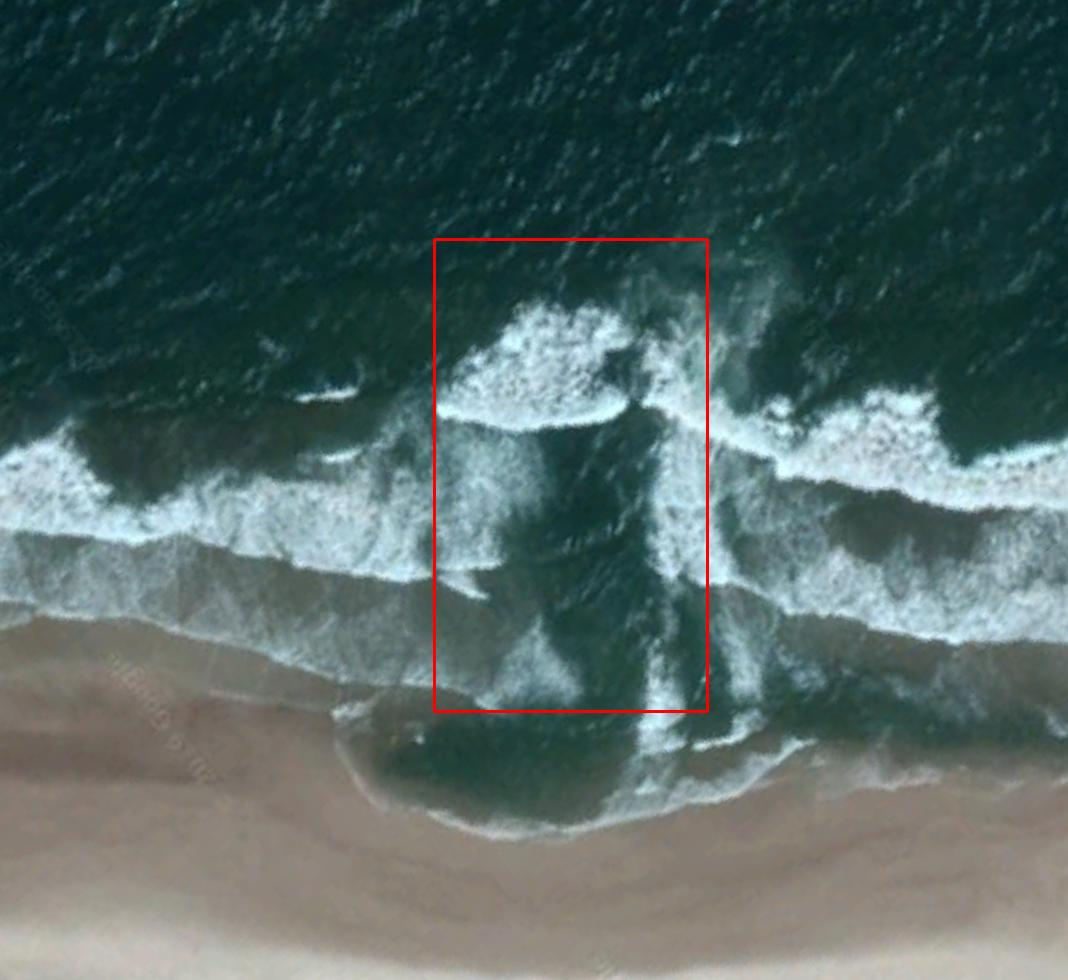

rip-1728.png


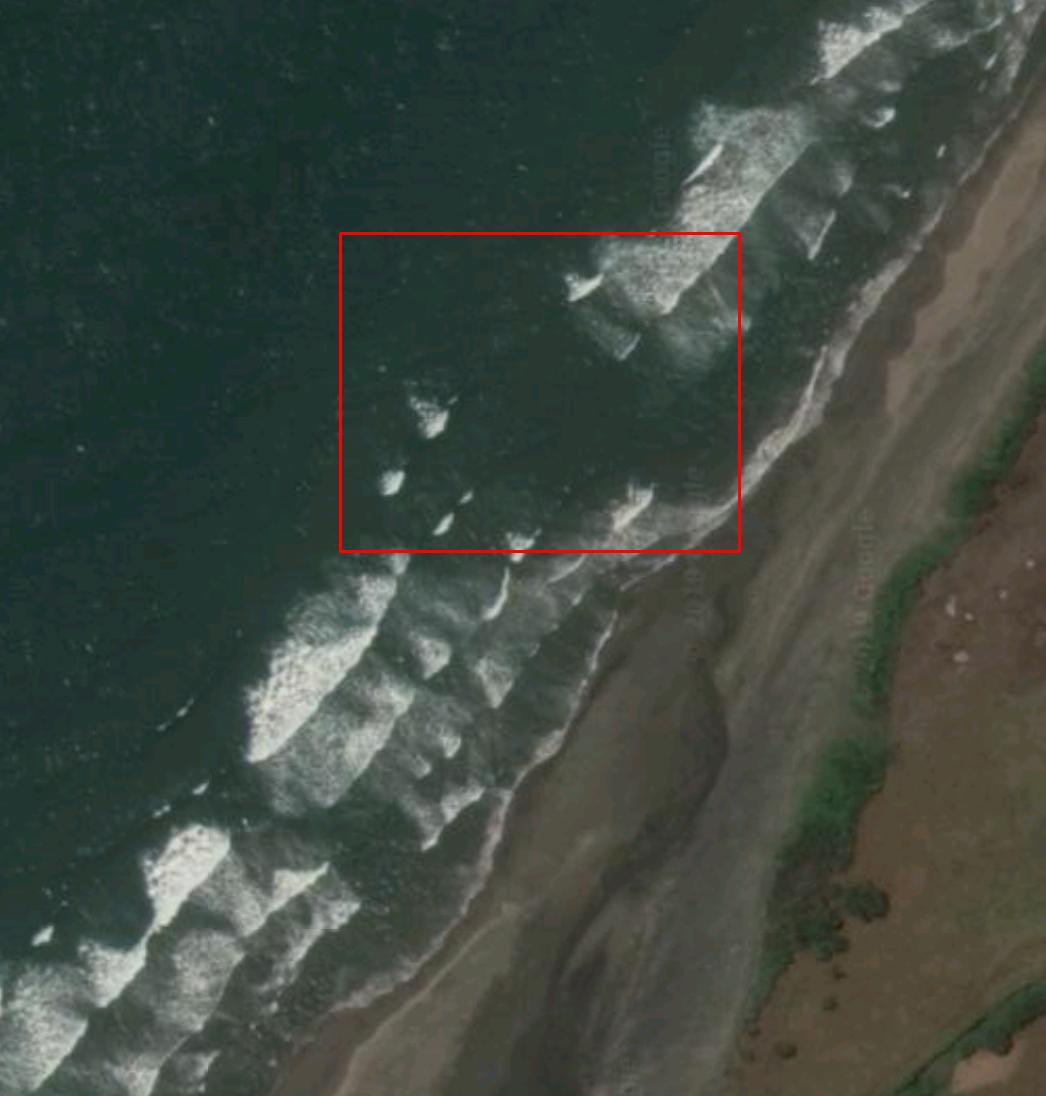

rip-746.png


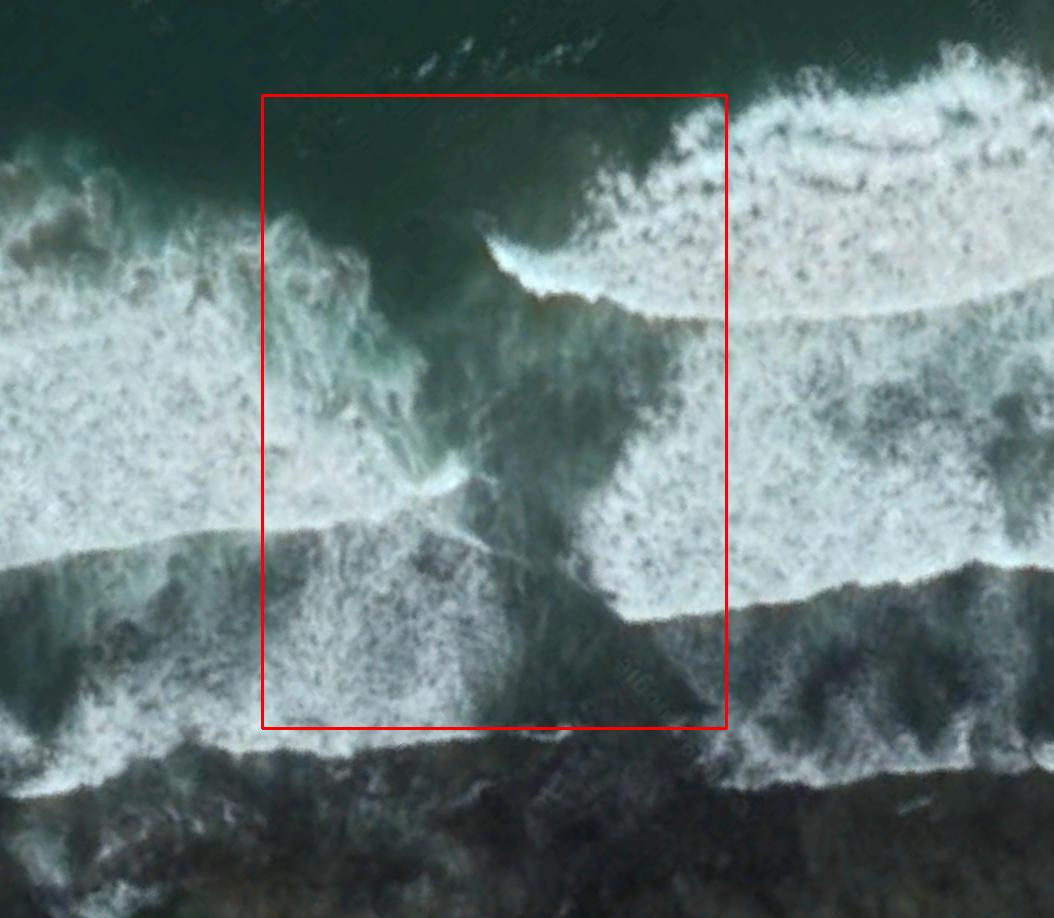

rip-1760.png


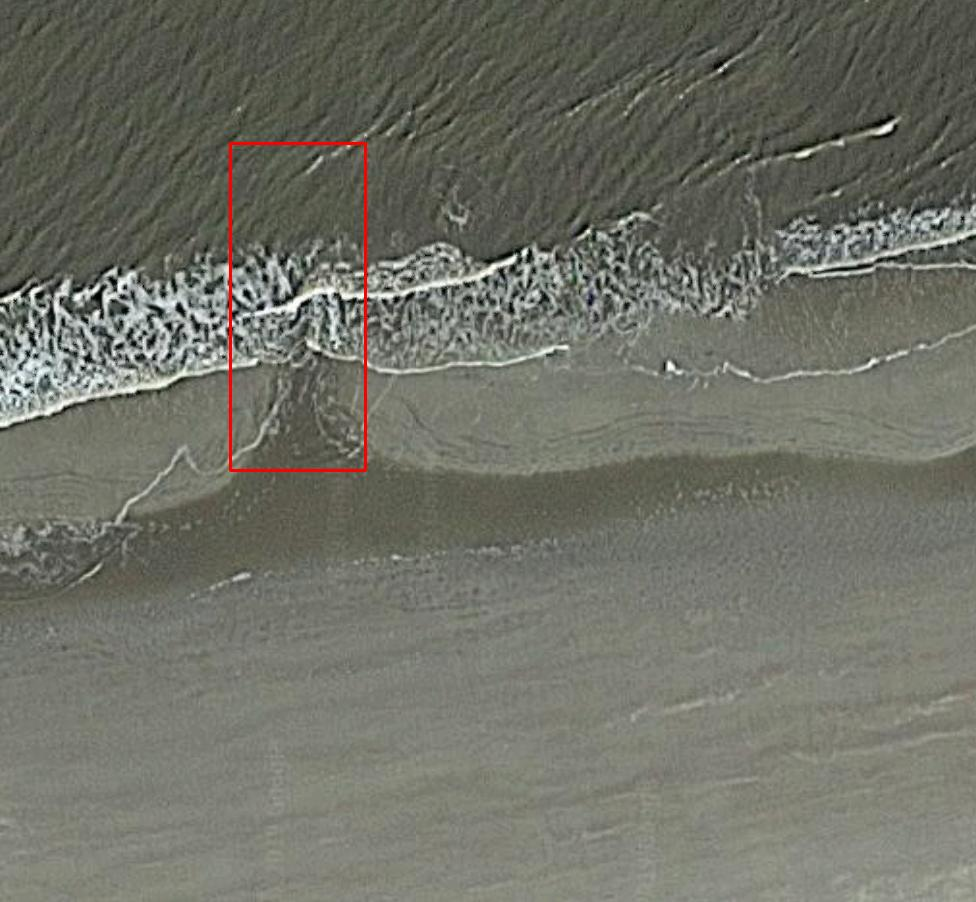

rip-780.png


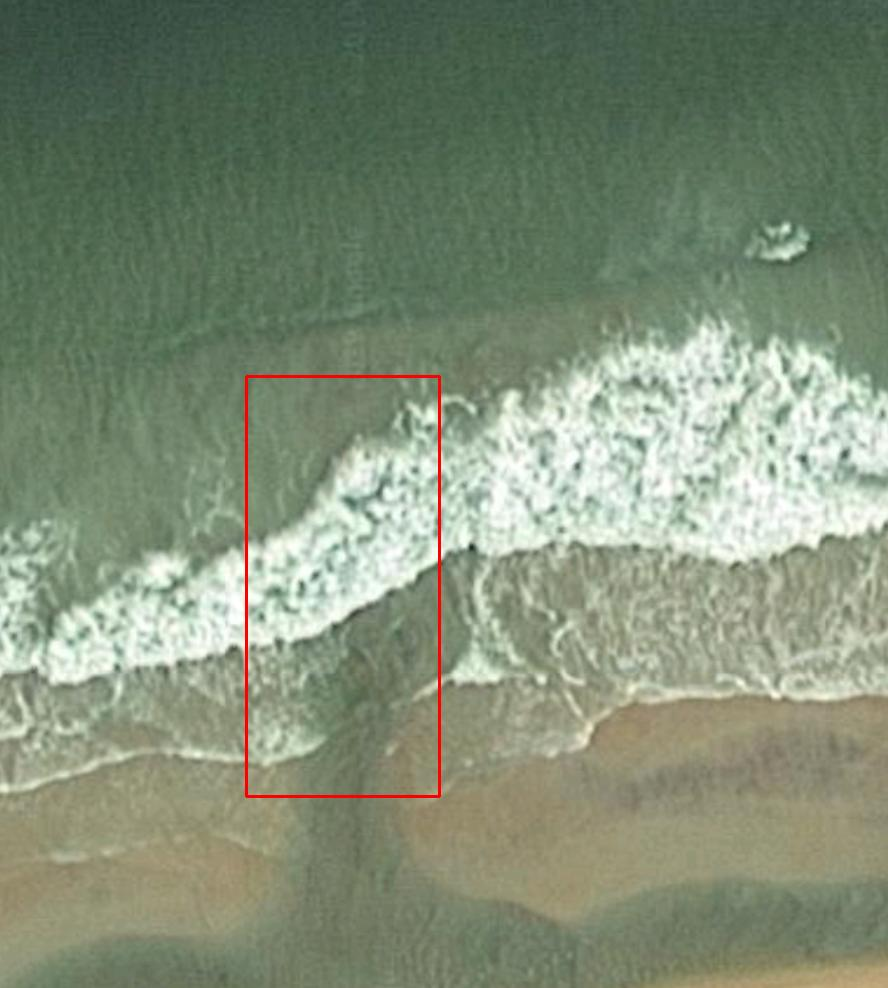

rip-25.png


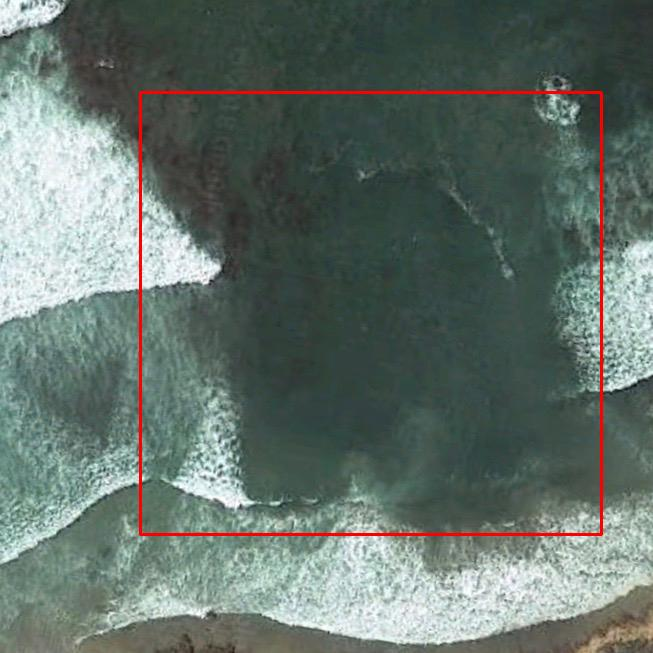

rip-813.png


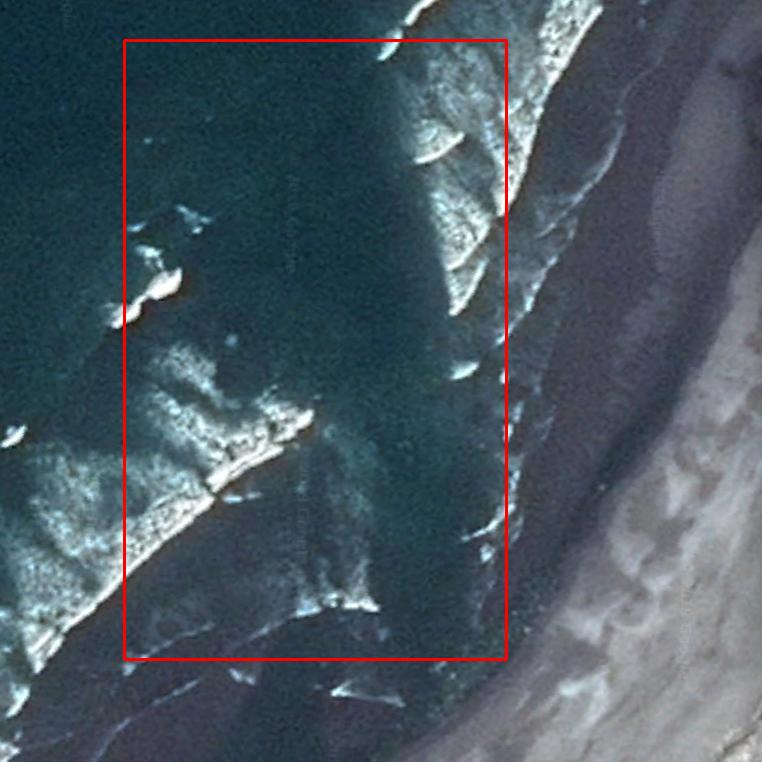

In [83]:
# Test box

print_initial_bbox(images_dict[:20])

# from IPython.display import clear_output, Image, display
# image = cv.imread( "./training_data/with_rips/rip-4.png" )

# img = image.copy()

# cv.rectangle(img, (int(images_dict[267]['xmax']), int(images_dict[267]['ymax'])), (int(images_dict[267]['xmin']), int(images_dict[267]['ymin'])), (0, 0, 255), 2)

# show_image(img)